## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [8]:
N_countsSimulator = n_counts_simulator.Model()

In [9]:
N_countsSimulator.N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [12]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 9)
z_max = np.linspace(0.2, 1.0, num = 9)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [14]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([2.01375933e+04, 4.21819225e+04, 6.15932449e+04, 7.42789101e+04,
       7.92155533e+04, 7.73349713e+04, 7.05138175e+04, 6.08214612e+04,
       5.00615557e+04, 2.66747919e+03, 4.92190805e+03, 6.24078572e+03,
       6.45463132e+03, 5.83486556e+03, 4.77435379e+03, 3.60888575e+03,
       2.55307769e+03, 1.70548356e+03, 1.21730998e+02, 1.79035710e+02,
       1.76398359e+02, 1.38638874e+02, 9.32196154e+01, 5.55529414e+01,
       2.99497101e+01, 1.47992319e+01, 6.76248388e+00])

## Fisher contours

### Derivative (five-point stencil)

In [16]:
def compute_derivative(theta_fiducial, param_index, delta_param, log10masses = np.linspace(14, 15.5, num = 4),
                       z_min = np.linspace(0.1, 0.9, num = 9), z_max = np.linspace(0.2, 1.0, num = 9)):
    
    log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))
    
    theta_2h = theta_fiducial
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h)
    
    theta_h = theta_fiducial
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h)
    
    theta_h_neg = theta_fiducial
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h_neg)
    
    
    theta_2h_neg = theta_fiducial
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h_neg)
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

In [17]:
def compute_derivative_reg(theta_fiducial, param_index, delta_param, log10masses = np.linspace(14, 15.5, num = 4),
                       z_min = np.linspace(0.1, 0.9, num = 5), z_max = np.linspace(0.2, 1.0, num = 5)):
    
    log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))
    
    theta_h = theta_fiducial
    theta_h[param_index] = theta_h[param_index] + delta_param/2
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h)
    
    theta_h_neg = theta_fiducial
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param/2
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h_neg)
    
    deriv = (counts_h - counts_h_neg)/delta_param
    
    return deriv

### Covariance matrix

In [19]:
cov_matrix = np.diag(N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial))
cov_matrix_inv = np.linalg.inv(cov_matrix)

In [20]:
cov_matrix_inv.shape

(27, 27)

### $\Omega_{cdm}h^{2}$

#### check stability of derivatives 

#### (1) 1% of fiducial value

In [21]:
steps = np.linspace(0.005, 0.02, num = 10)
omega_cdm_steps = steps*theta_fiducial[0]
sigma8_steps = steps*theta_fiducial[1]

In [22]:
deriv_base_cdm = compute_derivative(theta_fiducial, 0, 0.01*theta_fiducial[0])
deriv_base_sigma8 = compute_derivative(theta_fiducial, 1, 0.01*theta_fiducial[1])

In [23]:
for i in range(len(steps)):
    deriv_temp1 = compute_derivative(theta_fiducial, 0, omega_cdm_steps[i])
    deriv_temp2 = compute_derivative(theta_fiducial, 1, sigma8_steps[i])
    if i==0:
        deriv_omega_cdm = deriv_temp1
        deriv_sigma8 = deriv_temp2
    else:
        deriv_omega_cdm = np.vstack((deriv_omega_cdm, deriv_temp1))
        deriv_sigma8 = np.vstack((deriv_sigma8, deriv_temp2))
    
    print(i)

0
1
2
3
4
5
6
7
8
9


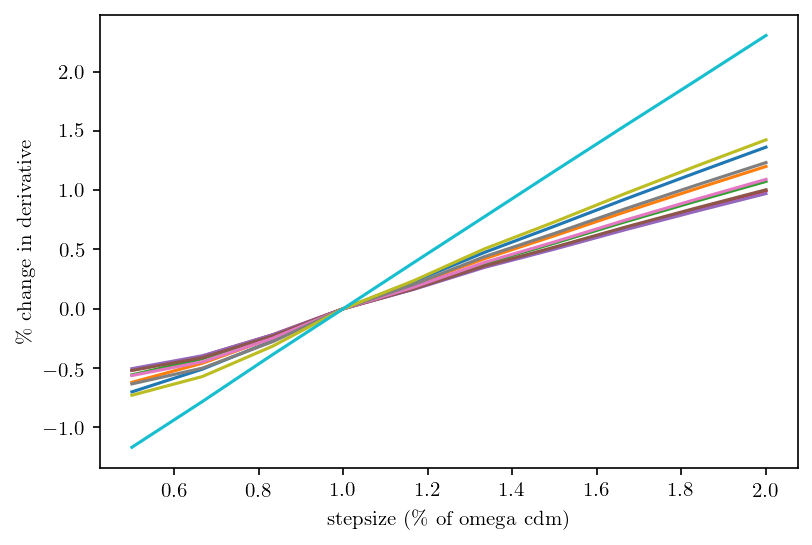

In [24]:
plt.figure(i)
plt.ylabel('\% change in derivative')
plt.xlabel('stepsize (\% of omega cdm)')
for i in range(deriv_omega_cdm.shape[0]):
    plt.plot(100*steps, 100*(deriv_omega_cdm[:, i]/deriv_base_cdm[i] - 1))

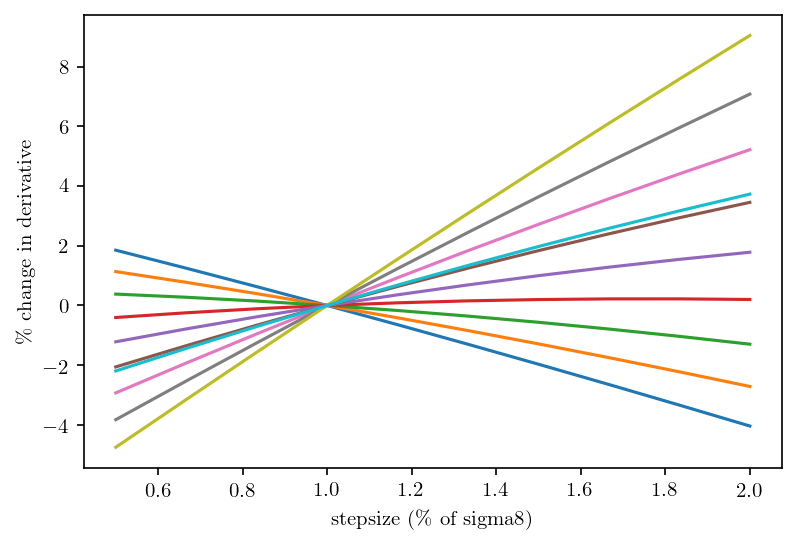

In [25]:
plt.figure(i)
plt.ylabel('\% change in derivative')
plt.xlabel('stepsize (\% of sigma8)')
for i in range(deriv_sigma8.shape[0]):
    plt.plot(steps*100, 100*(deriv_sigma8[:, i]/deriv_base_sigma8[i] - 1))

#### (2) 5% of fiducial value

In [26]:
steps = np.linspace(0.025, 0.1, num = 10)
omega_cdm_steps = steps*theta_fiducial[0]
sigma8_steps = steps*theta_fiducial[1]

In [27]:
deriv_base_cdm = compute_derivative(theta_fiducial, 0, 0.05*theta_fiducial[0])
deriv_base_sigma8 = compute_derivative(theta_fiducial, 1, 0.05*theta_fiducial[1])

In [28]:
for i in range(len(steps)):
    deriv_temp1 = compute_derivative(theta_fiducial, 0, omega_cdm_steps[i])
    deriv_temp2 = compute_derivative(theta_fiducial, 1, sigma8_steps[i])
    if i==0:
        deriv_omega_cdm = deriv_temp1
        deriv_sigma8 = deriv_temp2
    else:
        deriv_omega_cdm = np.vstack((deriv_omega_cdm, deriv_temp1))
        deriv_sigma8 = np.vstack((deriv_sigma8, deriv_temp2))
    
    print(i)

0
1
2
3
4
5
6
7
8
9


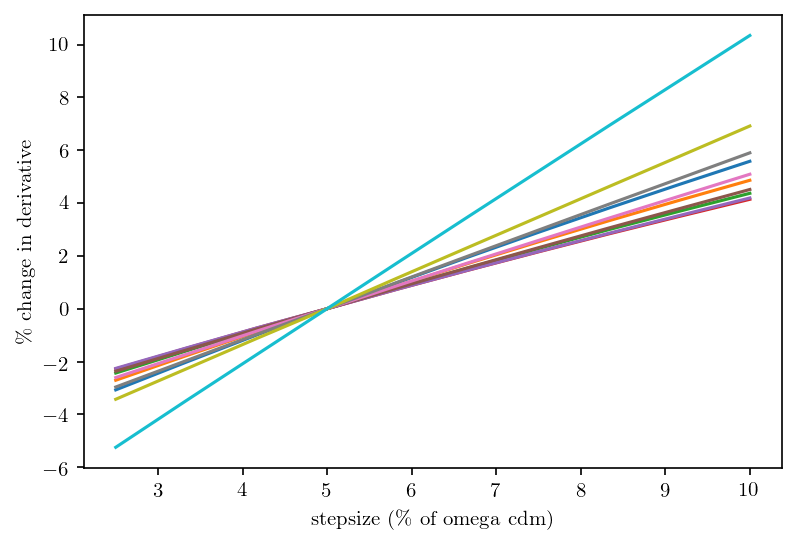

In [29]:
plt.figure(i)
plt.ylabel('\% change in derivative')
plt.xlabel('stepsize (\% of omega cdm)')
for i in range(deriv_omega_cdm.shape[0]):
    plt.plot(100*steps, 100*(deriv_omega_cdm[:, i]/deriv_base_cdm[i] - 1))

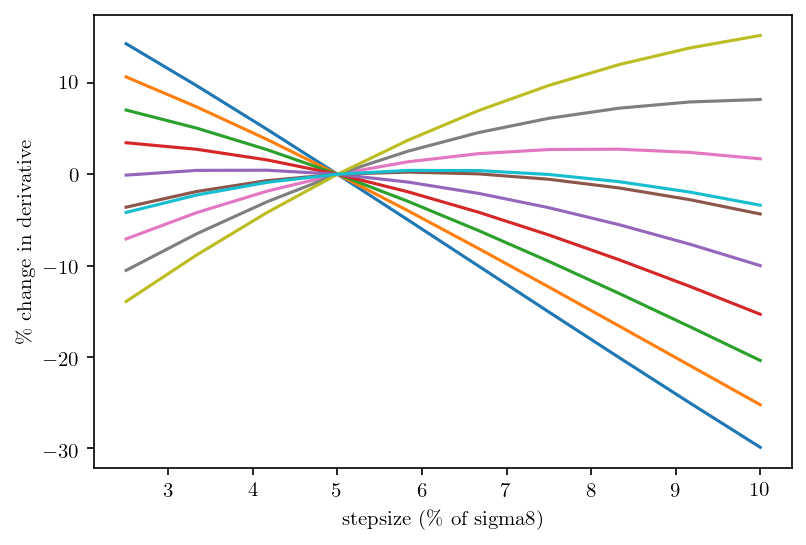

In [30]:
plt.figure(i)
plt.ylabel('\% change in derivative')
plt.xlabel('stepsize (\% of sigma8)')
for i in range(deriv_sigma8.shape[0]):
    plt.plot(steps*100, 100*(deriv_sigma8[:, i]/deriv_base_sigma8[i] - 1))

### Compute Fisher matrix

In [31]:
fisher_matrix = np.zeros((2, 2))
fisher_matrix 

array([[0., 0.],
       [0., 0.]])

In [32]:
deriv_base_cdm = compute_derivative(theta_fiducial, 0, 0.01*theta_fiducial[0])
deriv_base_sigma8 = compute_derivative(theta_fiducial, 1, 0.01*theta_fiducial[1])

#### (1) compute diagonals

In [34]:
fisher_matrix[0, 0] = np.dot(np.dot(deriv_base_cdm.reshape(1, 27), cov_matrix_inv), deriv_base_cdm)
fisher_matrix[0, 0]

14256270.145814443

In [35]:
fisher_matrix[1, 1] = np.dot(np.dot(deriv_base_sigma8.reshape(1, 27), cov_matrix_inv), deriv_base_sigma8)
fisher_matrix[1, 1]

7690902.316885058

#### (2) compute off-diagonals

In [36]:
fisher_matrix[0, 1] = np.dot(np.dot(deriv_base_cdm.reshape(1, 27), cov_matrix_inv), deriv_base_sigma8)
fisher_matrix[1, 0] = fisher_matrix[0, 1]

#### (3) compute covariance matrix for the parameters

In [37]:
fisher_matrix

array([[14256270.14581444,  9550140.51674318],
       [ 9550140.51674318,  7690902.31688506]])

In [39]:
covariance_matrix = np.linalg.inv(fisher_matrix)
covariance_matrix 

array([[ 4.17113387e-07, -5.17948519e-07],
       [-5.17948519e-07,  7.73183807e-07]])

#### (4) make a triangle plot with fisher contours

In [41]:
import getdist
from getdist import plots, MCSamples
import matplotlib as mpl
from matplotlib.patches import Ellipse
from scipy.stats import norm
import matplotlib.pyplot as plt

In [39]:
Finv = covariance_matrix 

In [43]:
theta_cdm = np.linspace(0.116, 0.124, 1000)
norm_theta_cdm = norm.pdf(theta_cdm, theta_fiducial[0], np.sqrt(Finv[0, 0]))

theta_s8 = np.linspace(0.755, 0.765, 1000)
norm_theta_s8 = norm.pdf(theta_s8, theta_fiducial[1], np.sqrt(Finv[1, 1]))

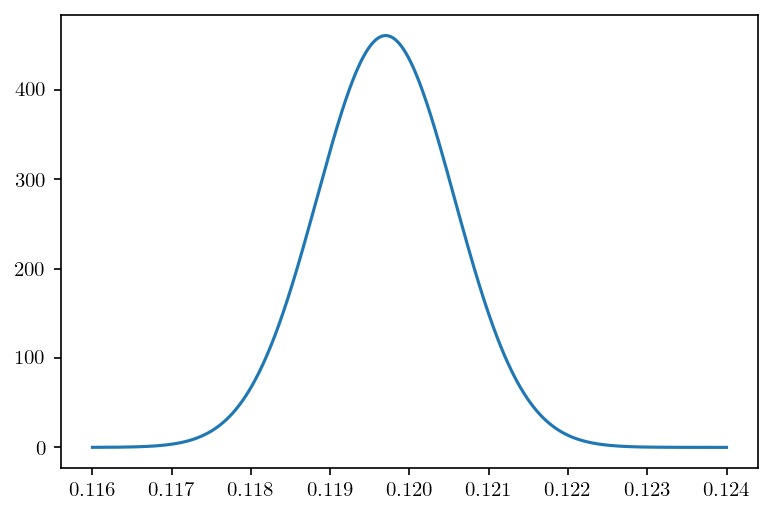

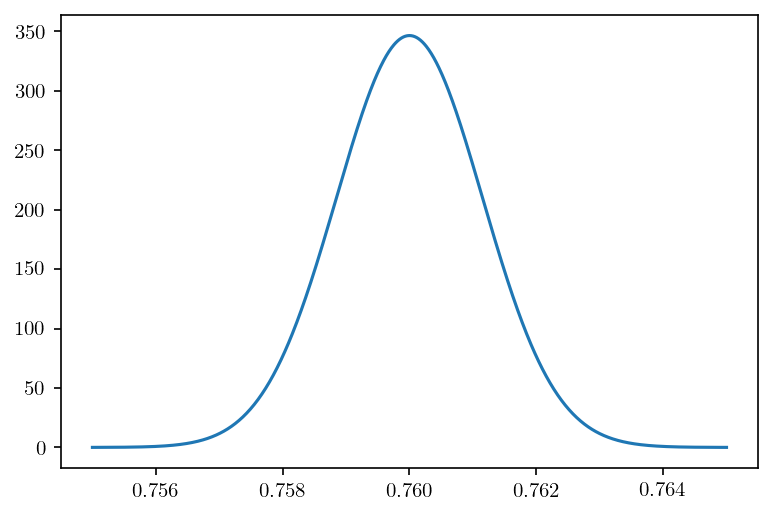

In [44]:
plt.figure()
plt.plot(theta_cdm, norm_theta_cdm)

plt.figure()
plt.plot(theta_s8, norm_theta_s8)

In [45]:
flat_samples = np.load('flat_samples_3000.npy')
flat_samples_cdm = [flat_samples[:, 0]]

mcmc_samples_cdm = [MCSamples(samples=s, 
                        names=['\\Omega_{cdm}h^{2}'], 
                        labels=['\\Omega_{cdm}h^{2}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275]}) 
              for i, s in enumerate(flat_samples_cdm)]

flat_samples_s8 = [flat_samples[:, 1]]

mcmc_samples_s8 = [MCSamples(samples=s, 
                        names=['\\sigma_{8}'], 
                        labels=['\\sigma_{8}'],
                        ranges={'\\sigma_{8}': [0.6, 1.1]})
              for i, s in enumerate(flat_samples_s8)]

Removed no burn in
Removed no burn in


In [52]:
flat_samples = np.load('flat_samples_1000.npy')
flat_samples

array([[0.1194165 , 0.7611435 ],
       [0.11936186, 0.760532  ],
       [0.11964474, 0.76039495],
       ...,
       [0.12012577, 0.75972211],
       [0.11937144, 0.76058127],
       [0.11995706, 0.75939909]])

In [47]:
print(np.mean(flat_samples[:, 0]), np.mean(flat_samples[:, 1]))
print(np.std(flat_samples[:, 0]), np.std(flat_samples[:, 1]))

0.11971567714337536 0.7599850696027783
0.0005043451467940708 0.0007115270767447572


In [48]:
print(np.sqrt(Finv[0, 0]), np.sqrt(Finv[1, 1]))

0.0008656665158790251 0.001151207023916567


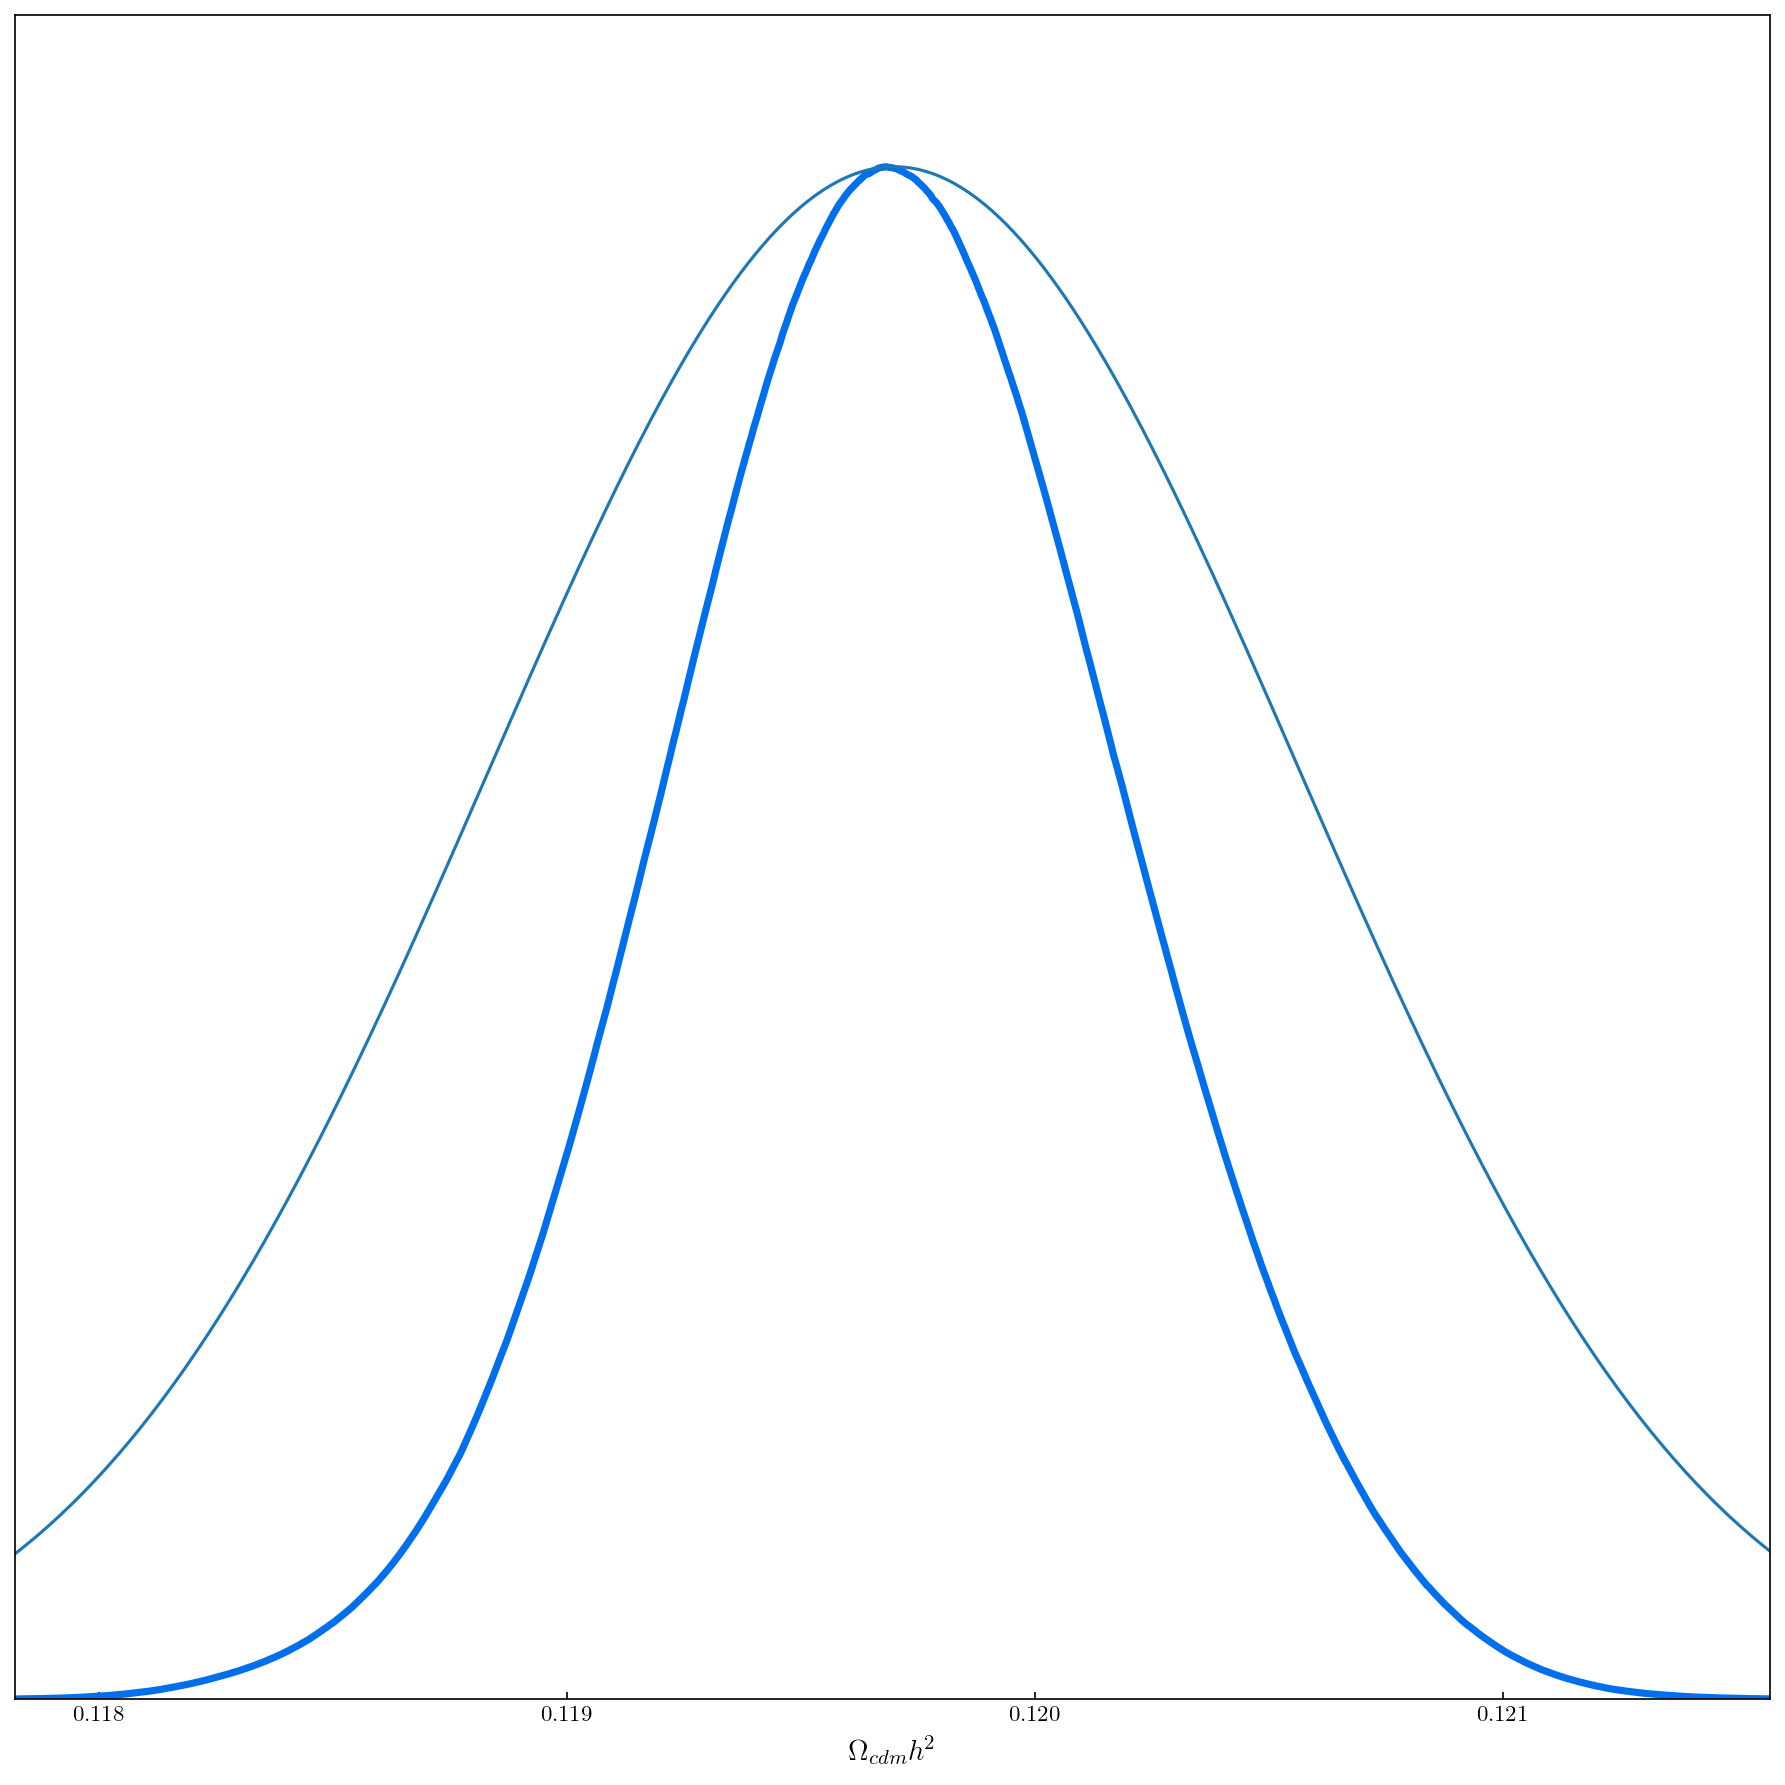

In [49]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(mcmc_samples_cdm, filled_compare=True, normalized=True)
ax0 = g.subplots[0,0]
ax0.plot(theta_cdm, norm_theta_cdm/np.max(norm_theta_cdm))

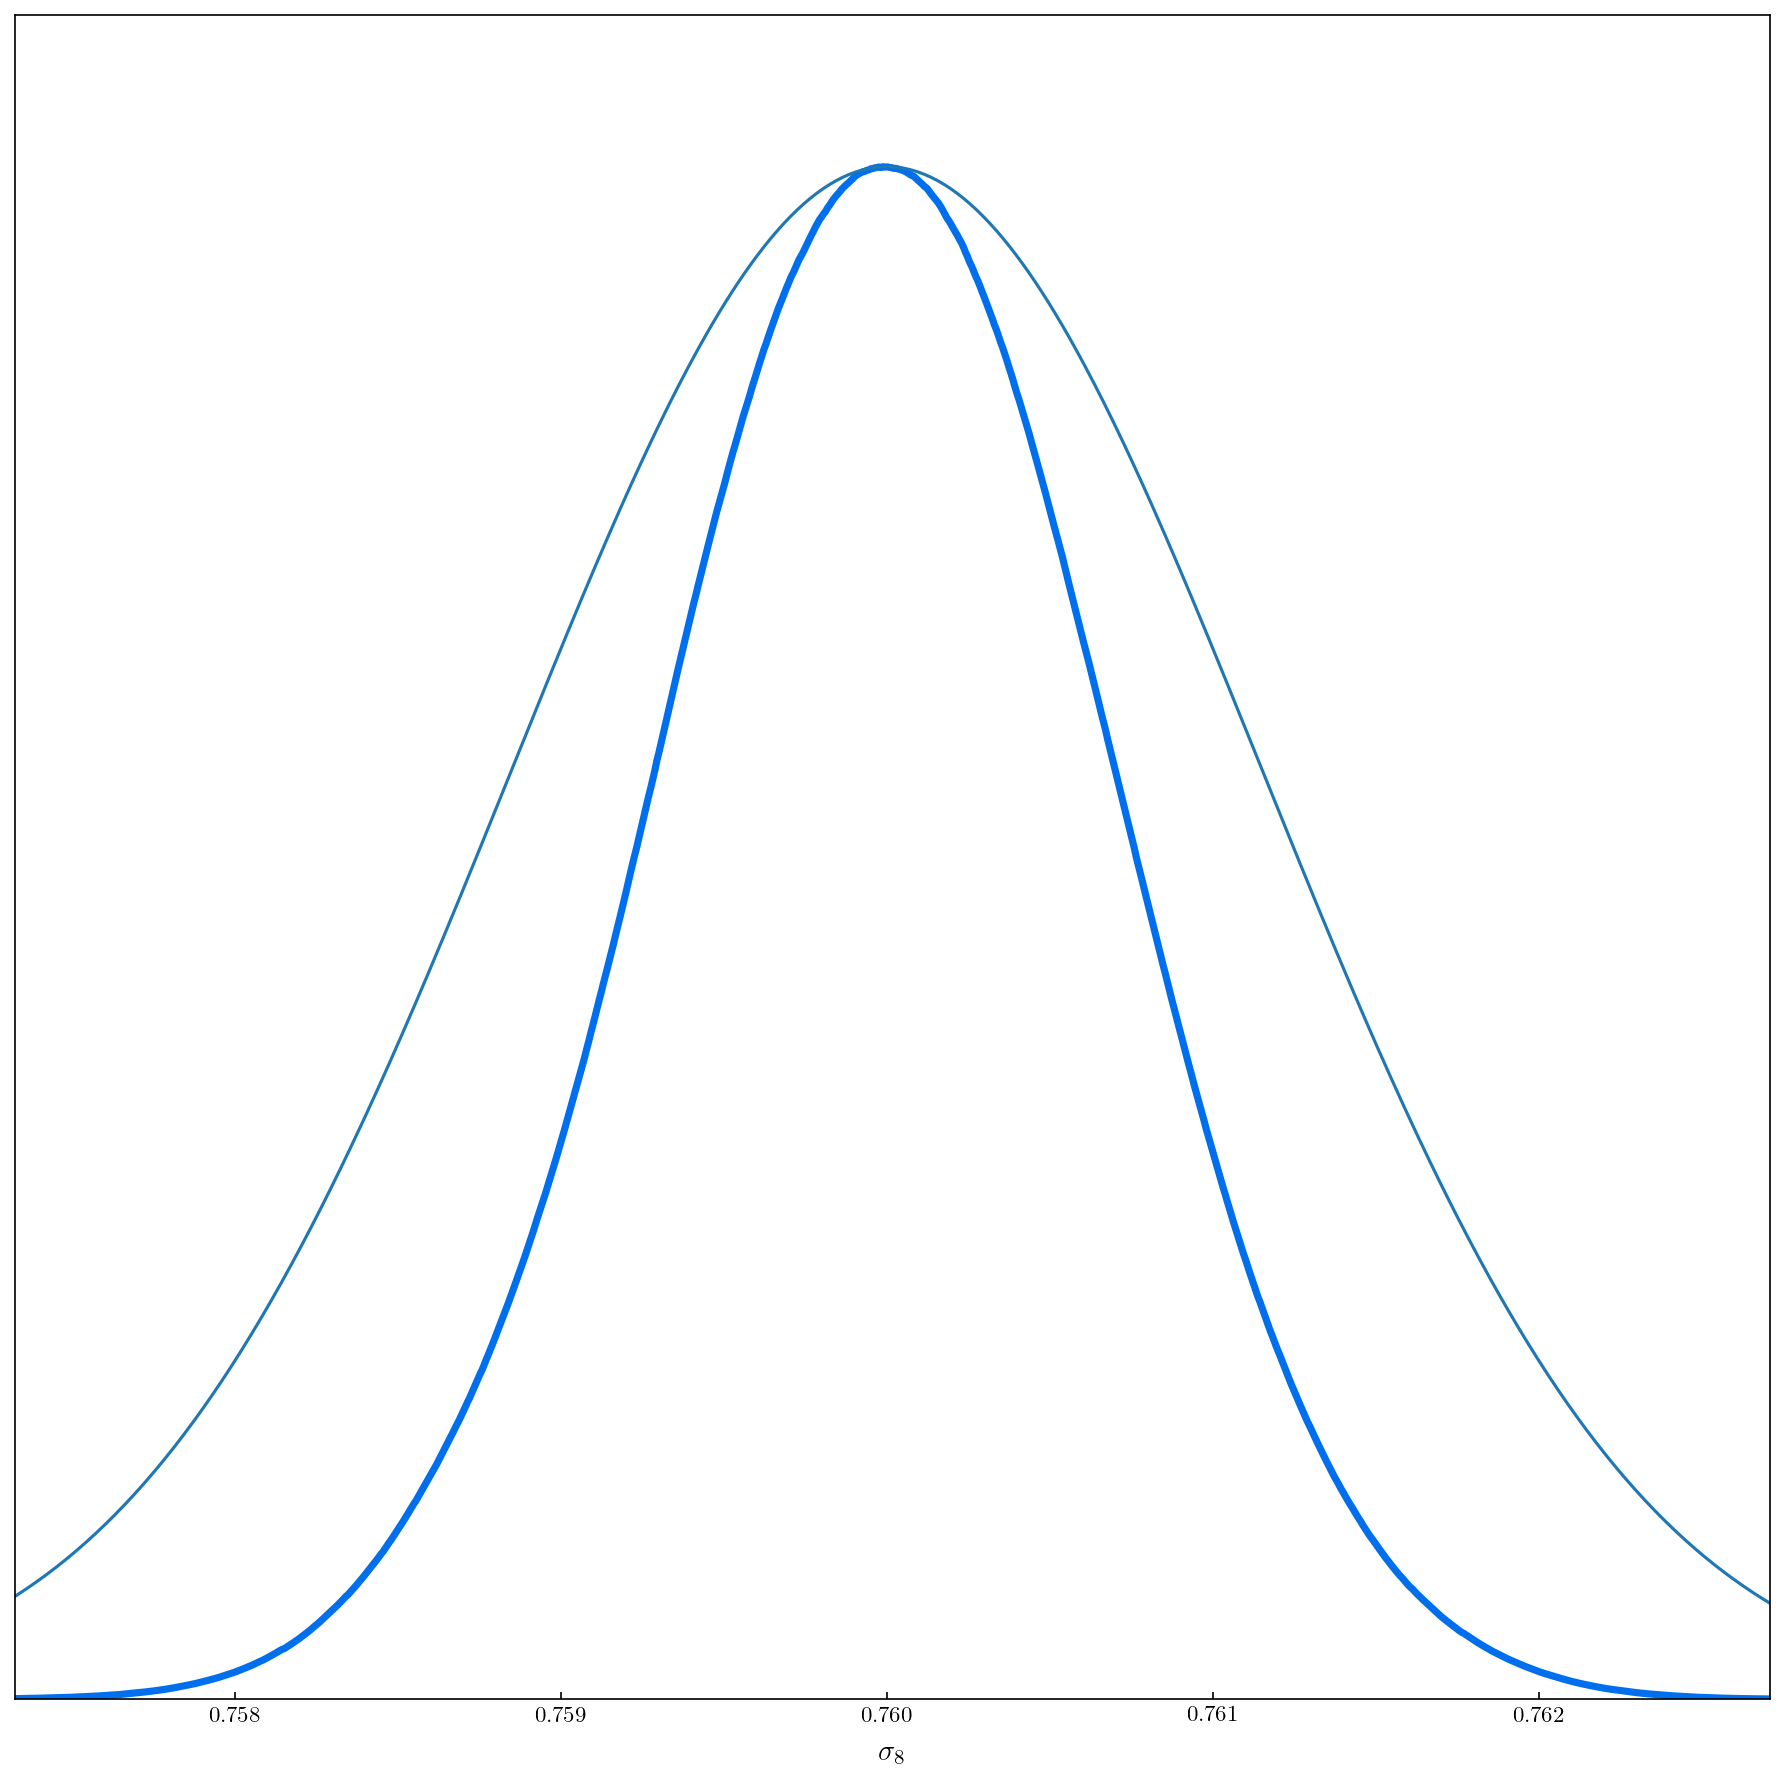

In [50]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(mcmc_samples_s8, filled_compare=True, normalized=True)
ax0 = g.subplots[0,0]
ax0.plot(theta_s8, norm_theta_s8/np.max(norm_theta_s8))

In [57]:
flat_samples = np.load('flat_samples_3000.npy')
flat_samples = [flat_samples]

mcmc_samples = [MCSamples(samples=s, 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(flat_samples)]

Removed no burn in


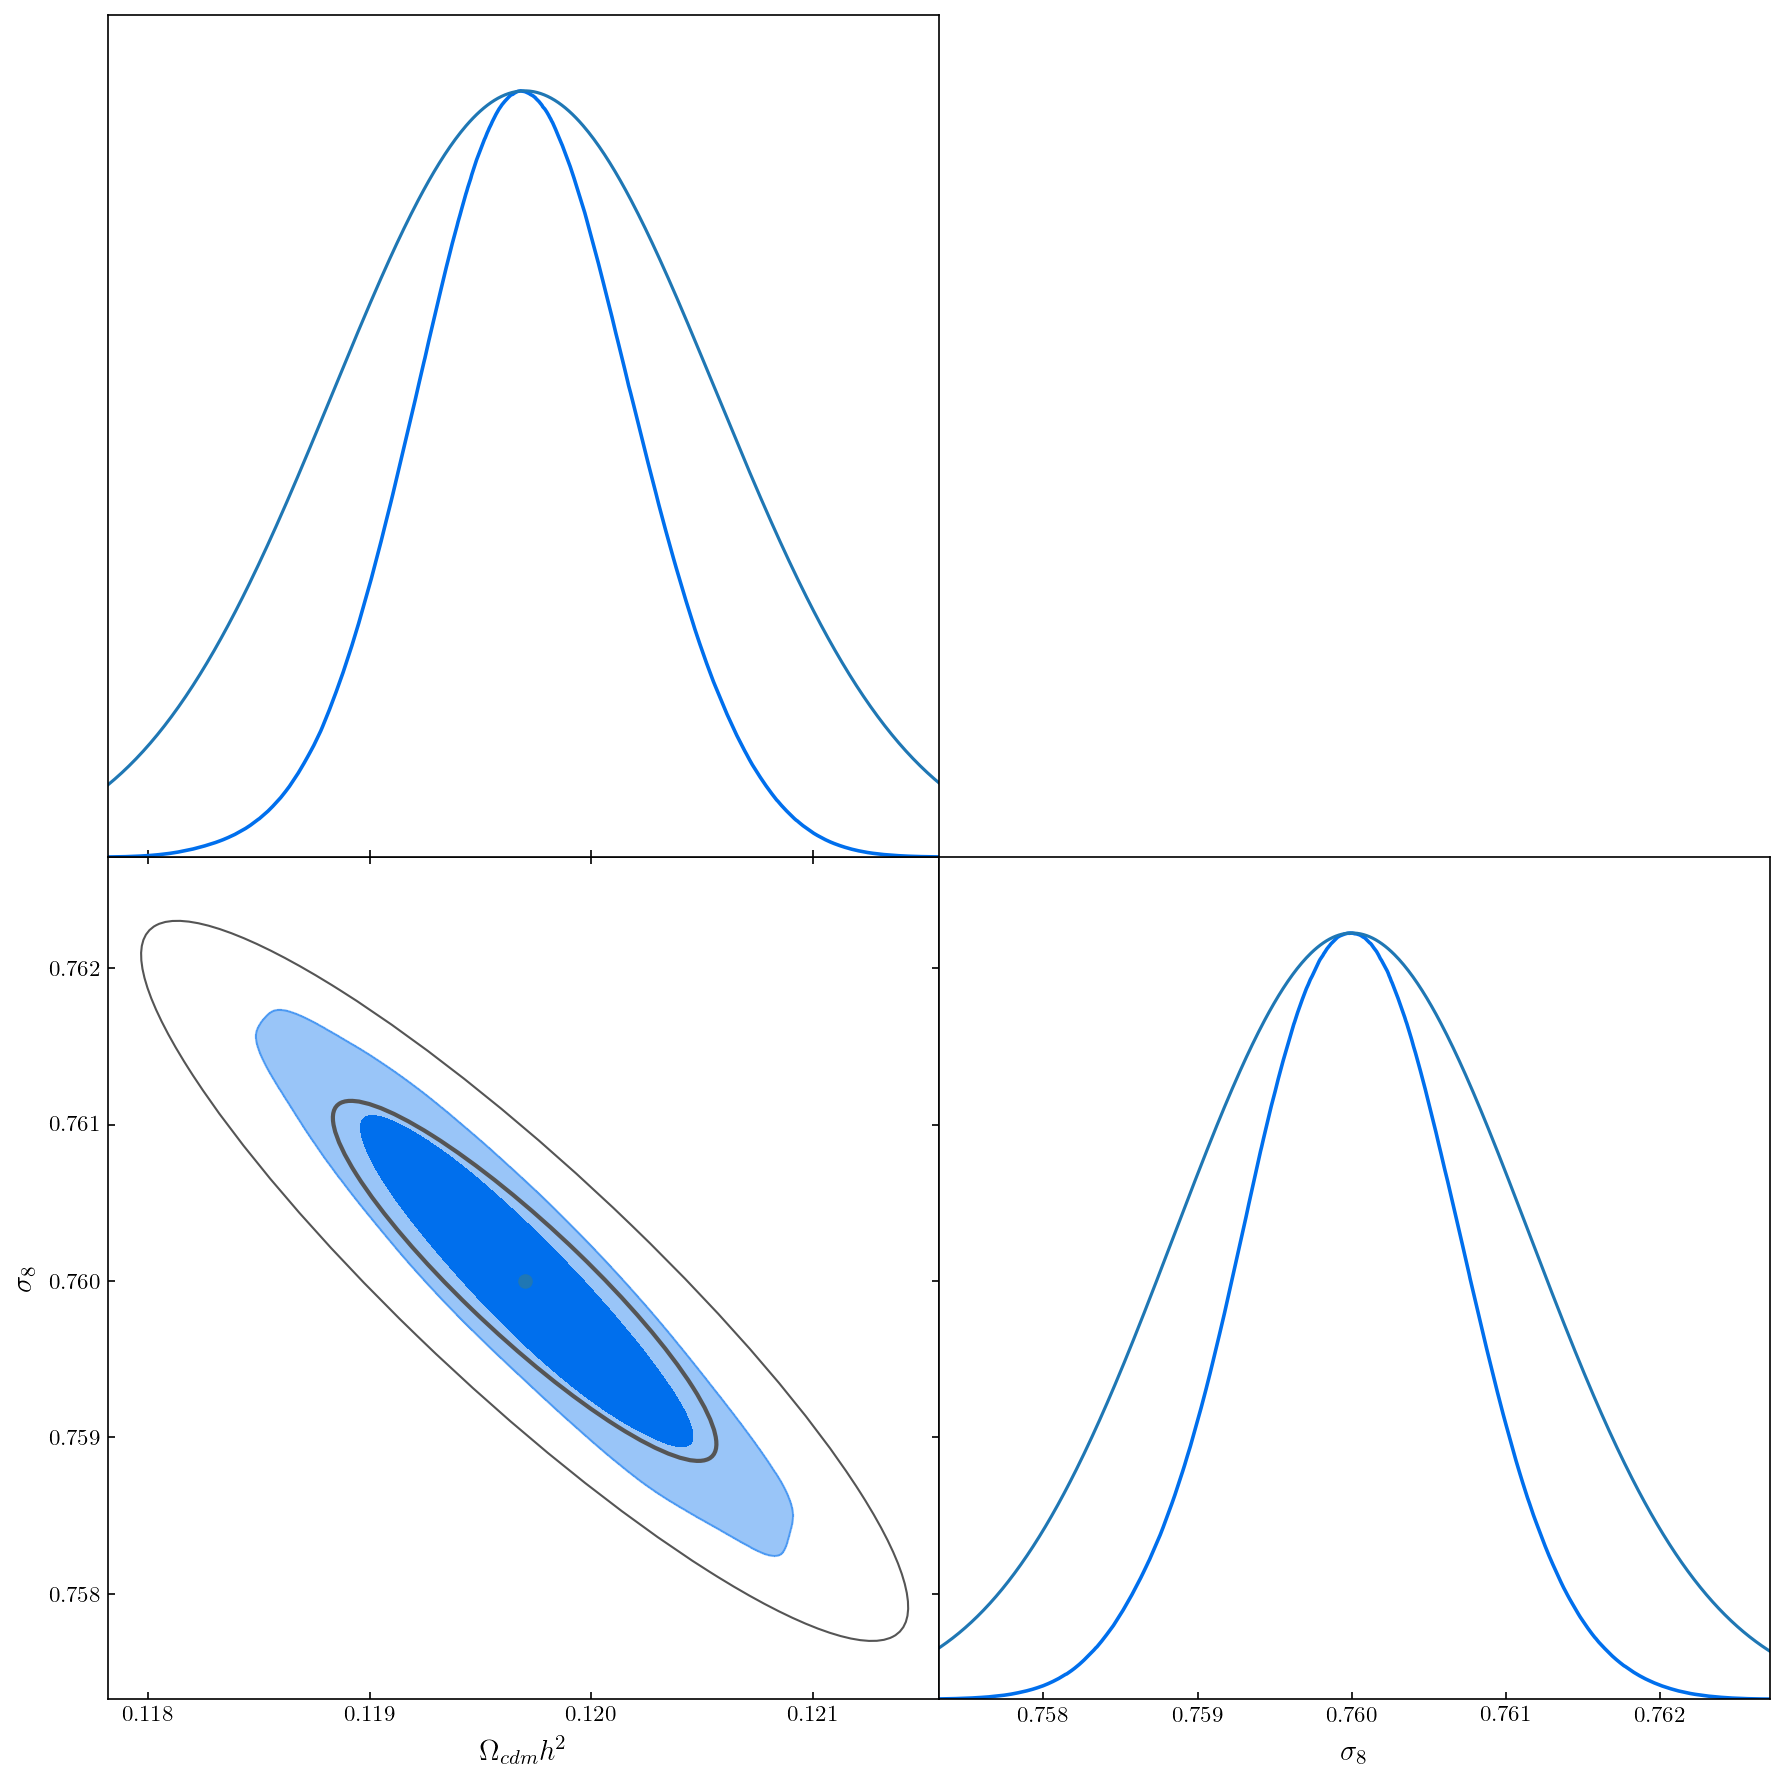

In [59]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(mcmc_samples, filled_compare=True, normalized=True)
ax0 = g.subplots[0,0]
ax0.plot(theta_cdm, norm_theta_cdm/np.max(norm_theta_cdm))
ax1 = g.subplots[1,1]
ax1.plot(theta_s8, norm_theta_s8/np.max(norm_theta_s8))

ax01 = g.subplots[1,0]
ax01.plot(theta_fiducial[0], theta_fiducial[1], marker='o', zorder=9, label='estimate')
eigval,eigvec = np.linalg.eig(Finv)
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))
w,h = 2*np.sqrt(eigval)
for n in [1,2]:
    ax01.add_patch(Ellipse(theta_fiducial, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))